## Heternuclear two-spin pulse acquire simulation in Liouville space, with random filed relaxation
Note: everything in SI units for clarity, frequncies in linear frequencies!

### 1) Imports

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### 2) Build spin operator matrices

In [2]:
Ix = 1/2*np.array([[0,1],[1,0]])
Iy = 1/2*np.array([[0,-1j],[1j,0]])
Iz = 1/2*np.array([[1,0],[0,-1]])
Ip = Ix+1j*Iy
Im = Ix-1j*Iy
Ia = np.array([[1,0],[0,0]])
Ib = np.array([[0,0],[0,1]])
E = np.eye(2)

#Construct spin operators in two-spin basis
I1x = np.kron(Ix,E);
I2x = np.kron(E,Ix);
I1y = np.kron(Iy,E);
I2y = np.kron(E,Iy);
I1z = np.kron(Iz,E);
I2z = np.kron(E,Iz);
I1p = np.kron(Ip,E);
I2p = np.kron(E,Ip);
I1m = np.kron(Im,E);
I2m = np.kron(E,Im);
I1a = np.kron(Ia,E);
I2a = np.kron(E,Ia);
I1b = np.kron(Ib,E);
I2b = np.kron(E,Ib);
E = np.eye(4);

### 3) Set Hamiltonian parameters and build the matrix

In [3]:
offset1 = 8e3 #Offset 1
offset2 = -10e3 #Offset 2
J = 400 #J coupling

H0 = offset1*I1z + offset2*I2z + J*(I1z*I2z)

k_z_1 = 0.1e3
k_xy_1 = 0.1e3

T2_1=1/(k_xy_1+k_z_1)
T1_1=1/(2*k_xy_1)

k_xy_2 = 0.1*J
k_z_2 = k_xy_2

T2_2=1/(k_xy_2+k_z_2)
T1_2=1/(2*k_xy_2)

### 3) Set simulation parameters

In [4]:
rho0 = I1z # starting density operator
pulseOp = I1y # pulse operator
detOp = I1x + 1j*I1y # detection operator

rho_eq = I1z

dt = 10e-6 # sampling step, "dwell time"
nPoints = 1024*4 # length of acquisition
t=np.arange(nPoints)*dt # time vector

sig = np.zeros(nPoints,dtype=complex) # pre-allocation of signal vector

### 5) Actual simulation

In [6]:
#convert everything to Liouville space
H0_L = np.kron(H0,E)-np.kron(E,H0.T)
rho0_L = rho0.T.flatten()
pulseOp_L = np.kron(pulseOp,E)-np.kron(E,pulseOp.T)
detOp_L = detOp.conj().T.flatten()

rho_eq_L = rho_eq.T.flatten()


I1x_doub_comm = np.linalg.matrix_power(np.kron(I1x,E)-np.kron(E,I1x.T),2)
I1y_doub_comm = np.linalg.matrix_power(np.kron(I1y,E)-np.kron(E,I1y.T),2)
I1z_doub_comm = np.linalg.matrix_power(np.kron(I1z,E)-np.kron(E,I1z.T),2)

I2x_doub_comm = np.linalg.matrix_power(np.kron(I2x,E)-np.kron(E,I2x.T),2)
I2y_doub_comm = np.linalg.matrix_power(np.kron(I2y,E)-np.kron(E,I2y.T),2)
I2z_doub_comm = np.linalg.matrix_power(np.kron(I2z,E)-np.kron(E,I2z.T),2)

#generate Relaxation superoperator
R = k_z_1*(I1z_doub_comm)+k_xy_1*(I1x_doub_comm+I1y_doub_comm)\
   +k_z_2*(I2z_doub_comm)+k_xy_2*(I2x_doub_comm+I2y_doub_comm)


# start sim
rho_L = rho0_L

# apply pulse propagator to initial density operator
Upulse_L = expm(-1j*np.pi/2*pulseOp_L)
rho_L = Upulse_L@rho_L

# build propagator of free evolution, and acquire
U0_L = expm(-1j*2*np.pi*H0_L*dt-R*dt);

for i in range(nPoints):
    sig[i]= rho_L@detOp_L # detect
    rho_L = rho_eq_L+U0_L@(rho_L-rho_eq_L); # propagation


### 6) Plot real and imaginary part

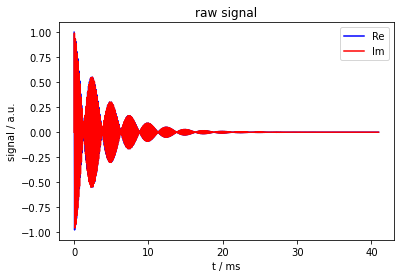

In [7]:
ax=plt.subplots()[1]
ax.plot(t*1e3,sig.real,color='blue')
ax.plot(t*1e3,sig.imag,color='red')
ax.set_title('raw signal')
ax.set_xlabel('t / ms')
ax.set_ylabel('signal / a.u.')
ax.legend(('Re','Im'))

### 7) Apodize, i.e. multiply with window function

In [8]:
twin = np.inf #Apodization parameter (no apodizaion)
win = np.exp(-t/twin)

#Apply window to signal
sig_apo = sig*win

# ax=plt.subplots()[1]
# ax.plot(t*1e3,sig_apo.real,color='red')
# ax.plot(t*1e3,sig_apo.imag,color='blue')
# ax.set_title('Apodized signal')
# ax.set_xlabel('t / ms')
# ax.set_ylabel('signal / a.u.')
# ax.legend(('Re','Im'))

### 8) Fourier transform with zero-filling, construction of the frequency vector

(0.0, 15.0)

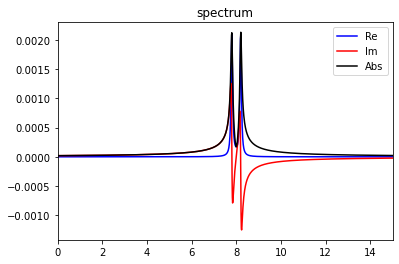

In [9]:
sig_apo[0]/=2 #Divide first point by 2 to get correct baseline
spec=np.fft.fftshift(np.fft.fft(sig_apo,2*nPoints))*dt

#Frequency vector
N=spec.size
nyqFreq = 1/(2*dt)
unitAxis=2/N*(np.arange(N)-N//2)
freq = nyqFreq*unitAxis

ax=plt.subplots()[1]
ax.plot(freq/1e3,spec.real,color='blue')
ax.plot(freq/1e3,spec.imag,color='red')
ax.plot(freq/1e3,np.abs(spec),color='black')
ax.set_title('spectrum')
ax.legend(('Re','Im','Abs'))

ax.set_xlim([0,15])

### 9) Basis transformation

In [11]:
Op=[E,I1z,I2z,I1z@I2z,
    I1x,I2x,I1y,I2y,
    I1x@I2z,I1z@I2x,I1y@I2z,I1z@I2y,
    I1x@I2x,I1y@I2y,I1x@I2y,I1y@I2x]

B=np.zeros([len(Op),len(Op)],dtype=complex)
for k,op in enumerate(Op):
    B[:,k]=op.T.flatten()
    B[:,k]=B[:,k]/np.sqrt(B[:,k].conj()@B[:,k])  #Normalize eigenvectors
    
#Check that B is unitary
print("B*B':")
print(B@B.conj().T)
    
#Convert to Operator basis
H0_L_B = B.conj().T@H0_L@B
rho0_L_B = B.conj().T@rho0_L
pulseOp_L_B = B.conj().T@pulseOp_L@B
detOp_L_B = B.conj().T@detOp_L
rho_eq_L_B = B.conj().T@rho_eq_L
R_B=B.conj()@R@B

B*B':
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 